<a href="https://colab.research.google.com/github/defedeleboria/project510kfda/blob/main/DeliciaFedele.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**UTN BA - CENTRO E-LEARNING** | Data Engineering

Tema: Device 510(k), FDA.

Recurso: https://open.fda.gov/apis/device/510k/

Alumno: *Fedele Boria, Delicia*

In [ ]:
#En base al feedback del Profesor, se hicieron las modificaciones de mejora para el Entrega 1, 2 y 3.

In [ ]:
#Para Entrega 1: Se mejoró la estructura y la organización. Se parametrizó algunas funciones para que el código sea mucho más simple, corto y
#no tenga repeticiones.

In [ ]:
#Para Entrega 2: Se mejoró la adecuación de la estructura con una carpeta raíz de “Bronze”, se evaluó la granularidad para finalmente particionar
#por fecha, en los datos incrementales. Para el estático, la columna que contiene un diccionario y listas, se aplanó y se separó en diferentes columnas.

In [ ]:
#Para Entrega 3: Se mejoró la optimización de recursos, cuando se crea la columna 'am-pm', se hizo que esta sea de tipo booleano, de manera que cuando
#la hora sea am, arroje el estado True y False si es pm. En el código faltó la creación de las tablas con SQLAlchemy, en donde se coloca el nombre de
#cada columna y el tipo de dato adecuado que debe tener cada una es éstas, entre otras configuraciones. Se corrigió esto para esta entrega. Por último,
#se corrigió el error en la carga de datos, en el parámetro 'if_exists'. Cambiar por tener el valor “append”, en vez de 'replace' ya que este lo que
#hacía era eliminar todos los datos existentes y cargarlos desde cero, ocacionando que se pierda toda información obtenida con anterioridad. Con 'append'
#conservamos los datos anteriores y respetamos también la configuración del tipo de dato de cada columna en cuestión.



---



**PRÁCTICO INTEGRADOR** - ENTREGA 1 - EXTRACCIÓN DE DATOS



---



**PRIMERA SECCIÓN** - INTRODUCCIÓN

La 510(k) es una presentación previa al mercado que se realiza ante la FDA para demostrar que el dispositivo que se pretende comercializar es al menos tan seguro y efectivo, es decir, sustancialmente equivalente, a un dispositivo legalmente comercializado que no está sujeto a la aprobación del PMA (Pre Market Approval), es decir, son aquellos que no presentan un mayor riesgo para la salud y la seguridad de los pacientes.



Los solicitantes deben comparar su dispositivo con uno o más dispositivos legalmente comercializados y respaldar sus afirmaciones de equivalencia sustancial. Un dispositivo legalmente comercializado, es aquel que se comercializó legalmente antes del 28 de mayo de 1976 (dispositivo anterior a las enmiendas), para el cual no se requiere un PMA, o que ha sido reclasificado de Clase III a Clase II o I, o bien, donde se ha encontrado sustancialmente equivalente a través del proceso 510(k).

El proyecto desarrollado, se basa en analizar la API de **Autorizaciones 510(k) de la FDA para Dispositivos Médicos** donde contiene detalles sobre productos específicos y los patrocinadores originales de las solicitudes de notificación previa al mercado. También incluye información administrativa y de seguimiento sobre las solicitudes, así como fechas de recepción y decisiones.

**SEGUNDA SECCIÓN** - LIBRERÍAS

In [ ]:
!pip install requests pandas

In [ ]:
!pip install fastparquet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.9 MB/s eta 0:00:00


In [ ]:
!pip install pyarrow

In [ ]:
!pip install psycopg2-binary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 26.3 MB/s eta 0:00:00


In [ ]:
import requests
import pandas as pd

In [ ]:
import json

In [ ]:
from datetime import datetime, date, timedelta

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
import random
from datetime import time

In [ ]:
from fastparquet import write
import pyarrow.parquet as pq
import pyarrow as pa
import os

In [ ]:
from pandas import json_normalize

In [ ]:
from sqlalchemy import create_engine

In [ ]:
from sqlalchemy import Column, Integer, String, Float, Date, Time, DateTime, Boolean, MetaData, Table

**TERCERA SECCIÓN** - DEFINICIÓN DE FUNCIONES

**Primera Parte: Exploración de Datos de la API.**



In [ ]:
#Se elije como base_api el parámetro date_received, en que el Centro de Control de Documentos de la FDA recibió la presentación
#para cualquier dispositivo médico.

In [ ]:
base_api = 'https://api.fda.gov/device/510k.json?count=date_received'
response = requests.get(base_api)
data = response.json()

In [ ]:
#Se opta por utilizar el siguiente bloque de código, para para automatizar la obtención de datos y su procesamiento
#en una estructura tabular que facilita su análisis, dado que openFDA tiene muchísimos datos y alternativas de trabajo.

In [ ]:
def get_data(base_api, endpoint, params=None):
    try:
        endpoint_url = f"{base_api}/{endpoint}"
        response = requests.get(endpoint_url, params=params)
        response.raise_for_status()
        try:
            data = response.json()
            data = data["results"]
        except:
            print("El formato de respuesta no es el esperado")
            return None
        return data
    except requests.exceptions.RequestException as e:
        print(f"La petición ha fallado. Código de error : {e}")
        return None

def build_table(json_data):
    df = pd.json_normalize(json_data)
    return df

In [ ]:
#Se define un endponint para el parámetro "Decision type is: Substantially Equivalent" para aquelos dispositivos médicos que
#en la presentación tiene esta característica en donde se está afirmando que el dispositivo es sustancialmente equivalente a
#un dispositivo médico ya existente en el mercado (conocido como "dispositivo de comparación") en términos de seguridad y eficacia.

In [ ]:
base_api = 'https://api.fda.gov/device/510k.json'
endpoint = 'search=decision_description:Substantially+Equivalent&count=decision_date'
endpoint_url = f"{base_api}?{endpoint}"

r = requests.get(endpoint_url)

In [ ]:
#Para ver la respuesta a la petición concreta, muestro simplemente "r".

In [ ]:
r

<Response [200]>

In [ ]:
#El endpoint refiere a la fecha que se tomó la desición (decision_date) de que un determinado dispositivo médico pasó su
#presentación y se estableció como Substantially Equivalent. La presentación alude a una fecha en la que fue recibida (date_received).

In [ ]:
#Se verifica si la solicitud fue exitosa, si es así, se convierte la respuesta a un diccionario JSON e imprimimos los datos.

In [ ]:
try:
    response = requests.get(base_api)
    response.raise_for_status()
    json_data = response.json()
    print(json_data)
except requests.exceptions.RequestException as e:
    print(f"La petición ha fallado. Código de error : {e}")

{'meta': {'disclaimer': 'Do not rely on openFDA to make decisions regarding medical care. While we make every effort to ensure that data is accurate, you should assume all results are unvalidated. We may limit or otherwise restrict your access to the API in line with our Terms of Service.', 'terms': 'https://open.fda.gov/terms/', 'license': 'https://open.fda.gov/license/', 'last_updated': '2023-11-20', 'results': {'skip': 0, 'limit': 1, 'total': 167046}}, 'results': [{'third_party_flag': 'N', 'city': 'WASHINGTON', 'advisory_committee_description': 'Cardiovascular', 'address_1': '1800 M ST., N.W.', 'address_2': '', 'statement_or_summary': 'Summary', 'product_code': 'DQX', 'openfda': {'registration_number': ['9616088', '3004859241', '3006260740', '3023209233', '3009211636', '1649869', '3013556777', '3022627847', '2134812', '9616662', '3013666336', '3013656790', '2024168', '3003780911', '3010425778', '3005334138', '3010665433', '3012179728', '3007695959', '2030624', '9680001', '3015543504

In [ ]:
#Se obtiene el conteo de todos los dispositivos médicos de tipo Substantially Equivalent.

In [ ]:
json_data = r.json()
pd.json_normalize(json_data["results"])

,time,count
0,19760715,4
1,19760716,19
2,19760719,19
3,19760720,60
4,19760721,8
...,...,...
11501,20231113,10
11502,20231114,14
11503,20231115,7
11504,20231116,14


In [ ]:
#Convierto "time" en formato fecha.

In [ ]:
df_subs_eq = pd.json_normalize(json_data["results"])
df_subs_eq['time'] = pd.to_datetime(df_subs_eq['time'])

In [ ]:
df_subs_eq

,time,count
0,1976-07-15,4
1,1976-07-16,19
2,1976-07-19,19
3,1976-07-20,60
4,1976-07-21,8
...,...,...
11501,2023-11-13,10
11502,2023-11-14,14
11503,2023-11-15,7
11504,2023-11-16,14


In [ ]:
#Grafico el endpoint "Decision type is: Substantially Equivalent" con el objeto de visualizar mejor los datos.
#Aclaración: Dada la cantidad de datos, se opta por graficar por año (desde 1976 en adelante).

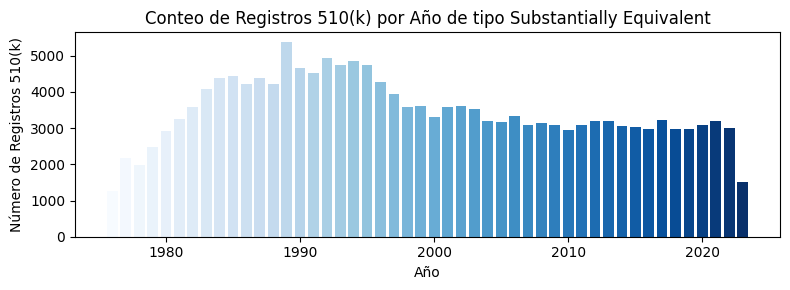

In [ ]:
results = data['results']
dates = pd.to_datetime([entry['time'] for entry in results])
years = dates.year

df_subs_eq = pd.DataFrame({'Año': years, 'Recuento': [entry['count'] for entry in results]})
df_subs_eq = df_subs_eq.groupby('Año')['Recuento'].sum().reset_index()

n = len(df_subs_eq)
colores = plt.cm.Blues(np.linspace(0, 1, n))

plt.figure(figsize=(8, 3))
plt.bar(df_subs_eq['Año'], df_subs_eq['Recuento'], color=colores)
plt.xlabel('Año')
plt.ylabel('Número de Registros 510(k)')
plt.title('Conteo de Registros 510(k) por Año de tipo Substantially Equivalent')

plt.tight_layout()
plt.show()

In [ ]:
#Se dispone obtener detalles de todos los dispositivos médicos del tipo Substantially Equivalent.

In [ ]:
#Un identificador de tres letras asignado a una categoría de dispositivo. La asignación se basa en la clasificación de dispositivos
#médicos designada según 21 CFR Partes 862-892 y la tecnología y el uso previsto del dispositivo. Ocasionalmente, estos códigos
#cambian con el tiempo.

In [ ]:
params = {
    'search': 'decision_description:Substantially+Equivalent&count=decision_date',
    'count': 'product_code'
}

In [ ]:
response = requests.get(base_api, params=params)
if response.status_code == 200:
    data = response.json()

In [ ]:
for item in data['results']:
        product_code = item['term']
        count = item['count']
        sub_eq_pc = pd.DataFrame(data['results'], columns=['term', 'count'])

In [ ]:
sub_eq_pc

,term,count
0,GEX,2659
1,GEI,2153
2,LLZ,2124
3,LYY,1943
4,DZE,1457
...,...,...
95,JTN,317
96,INI,311
97,ODP,311
98,MNH,308


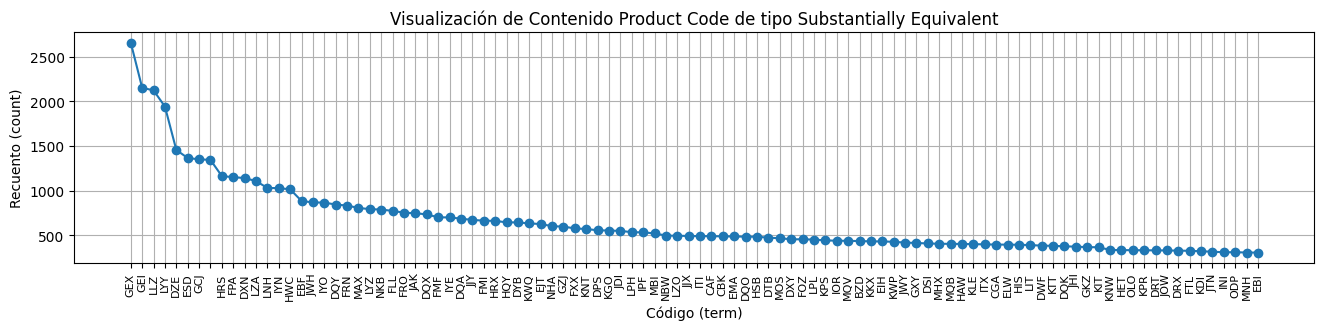

In [ ]:
plt.figure(figsize=(16, 3))
plt.plot(sub_eq_pc['term'], sub_eq_pc['count'], marker='o')
plt.xlabel('Código (term)')
plt.ylabel('Recuento (count)')
plt.title('Visualización de Contenido Product Code de tipo Substantially Equivalent')
plt.xticks(rotation=90, fontsize=8)
plt.grid(True)
plt.show()

In [ ]:
#Cada "term" y "count" está asociado a un grupo de dispositivos médicos que se recibió y se calificó en determinada fecha.
#Para profundizar el detalle, se afina los resultados.

In [ ]:
base_api = 'https://api.fda.gov/device/510k.json'

In [ ]:
params = {
    'search': 'decision_description:Substantially+Equivalent',
    'limit': 1000
}

In [ ]:
response = requests.get(base_api, params=params)
if response.status_code == 200:
    data = response.json()

In [ ]:
sub_eq_body = pd.DataFrame(data['results'])

In [ ]:
sub_eq_body.head()

,third_party_flag,city,advisory_committee_description,address_1,address_2,statement_or_summary,product_code,openfda,zip_code,applicant,...,advisory_committee,contact,expedited_review_flag,k_number,state,date_received,review_advisory_committee,postal_code,decision_description,clearance_type
0,N,WASHINGTON,Cardiovascular,"1800 M ST., N.W.",,Summary,DQX,"{'registration_number': ['9616088', '300485924...",20036,"PIOLAX MEDICAL DEVICES, INC.",...,CV,ELIZABETH BIERMAN,,K980977,DC,1998-03-16,CV,20036,Substantially Equivalent,Traditional
1,N,SAN CLEMENTE,General Hospital,951 CALLE AMANECER,,Summary,ONB,"{'registration_number': ['3010423292', '300834...",92673,ICU MEDICAL INC,...,HO,Jason Ma,,K170110,CA,2017-01-12,HO,92673,Substantially Equivalent,Traditional
2,N,McHenry,Cardiovascular,803 N. Front St. Suite 3,,,DTD,"{'registration_number': ['2649622', '300938006...",60050,"TELECTRONICS, INC.",...,CV,,,K782097,IL,1978-12-18,CV,60050,Substantially Equivalent,Traditional
3,N,McHenry,"General, Plastic Surgery",803 N. Front St. Suite 3,,,FZE,"{'registration_number': ['3010287685', '182552...",60050,"SURGICAL TECHNOLOGY LABORATORIES, INC.",...,SU,,,K801074,IL,1980-05-06,SU,60050,Substantially Equivalent,Traditional
4,N,GIBBSTOWN,Clinical Toxicology,480 DEMOCRAT RD.,,,LAN,"{'registration_number': ['9610529', '300379511...",08027,"EM DIAGNOSTIC SYSTEMS, INC.",...,TX,RAYMOND L MILLER,,K873349,NJ,1987-08-20,TX,08027,Substantially Equivalent,Traditional


In [ ]:
#Defino cuáles son las columnas que se consideran importantes como resultado de la exploración de los datos.

In [ ]:
sub_eq_body = sub_eq_body[['product_code', 'date_received', 'decision_date', 'applicant', 'openfda', 'k_number']]

In [ ]:
sub_eq_body.head()

,product_code,date_received,decision_date,applicant,openfda,k_number
0,DQX,1998-03-16,1998-10-27,"PIOLAX MEDICAL DEVICES, INC.","{'registration_number': ['9616088', '300485924...",K980977
1,ONB,2017-01-12,2018-08-10,ICU MEDICAL INC,"{'registration_number': ['3010423292', '300834...",K170110
2,DTD,1978-12-18,1978-12-22,"TELECTRONICS, INC.","{'registration_number': ['2649622', '300938006...",K782097
3,FZE,1980-05-06,1980-06-17,"SURGICAL TECHNOLOGY LABORATORIES, INC.","{'registration_number': ['3010287685', '182552...",K801074
4,LAN,1987-08-20,1987-09-22,"EM DIAGNOSTIC SYSTEMS, INC.","{'registration_number': ['9610529', '300379511...",K873349


In [ ]:
#Si analizamos el cuadro anterior, a grades rasgos, vemos que entre la fecha de recepción y la de decisión, hay algunos meses de diferencia.

**Segunda Parte: Extracción de Datos de la API**

In [ ]:
#Se intenta obtener datos de mediciones relacionadas con dispositivos médicos "Substantially Equivalent" en los siete días previos a finalizar
#el mes de Octubre, del año actual 2023. Lo mismo se hará para dispositivos médicos "Traditional" y "Clase III."

In [ ]:
#Sobre la medición, los bloques exploratorios que comienzan con "endpoint" tendrá como objeto extraer información sobre la cantidad de dispositivos
#médicos para un caso u otro, respetando los nombres específicos en la base de datos de la FDA, durante los últimos siete días de Septiembre o durante todo
#el mes de Octubre del año actual, dependiendo de la fecha actual. Los resultados se almacenan en la variable "data" y se pueden procesar más adelante
#según sea necesario.

- EXTRACCIÓN DE DATOS **SUBSTANTIALLY EQUIVALENT**

In [ ]:
base_api = 'https://api.fda.gov/device/510k.json'

In [ ]:
endpoint = 'search=decision_description:Substantially+Equivalent&count=date_received'
current_date = datetime.utcnow()
if current_date.month == 10:
    start_date = current_date - timedelta(days=7)
else:
    start_date = datetime(current_date.year, 10, 1)
end_date = current_date
start_date_str = start_date.strftime("%Y-%m-%dT00:00:00Z")
end_date_str = end_date.strftime("%Y-%m-%dT23:59:59Z")
params = {
    "start": start_date_str,
    "end": end_date_str
}
response = requests.get(f"{base_api}?{endpoint}", params=params)

if response.status_code == 200:
    data = response.json()

In [ ]:
dr_sub_eq = pd.DataFrame(data['results'])

In [ ]:
dr_sub_eq

,third_party_flag,city,advisory_committee_description,address_1,address_2,statement_or_summary,product_code,openfda,zip_code,applicant,...,advisory_committee,contact,expedited_review_flag,k_number,state,date_received,review_advisory_committee,postal_code,decision_description,clearance_type
0,N,WASHINGTON,Cardiovascular,"1800 M ST., N.W.",,Summary,DQX,"{'registration_number': ['9616088', '300485924...",20036,"PIOLAX MEDICAL DEVICES, INC.",...,CV,ELIZABETH BIERMAN,,K980977,DC,1998-03-16,CV,20036,Substantially Equivalent,Traditional
1,N,SAN CLEMENTE,General Hospital,951 CALLE AMANECER,,Summary,ONB,"{'registration_number': ['3010423292', '300834...",92673,ICU MEDICAL INC,...,HO,Jason Ma,,K170110,CA,2017-01-12,HO,92673,Substantially Equivalent,Traditional
2,N,McHenry,Cardiovascular,803 N. Front St. Suite 3,,,DTD,"{'registration_number': ['2649622', '300938006...",60050,"TELECTRONICS, INC.",...,CV,,,K782097,IL,1978-12-18,CV,60050,Substantially Equivalent,Traditional
3,N,McHenry,"General, Plastic Surgery",803 N. Front St. Suite 3,,,FZE,"{'registration_number': ['3010287685', '182552...",60050,"SURGICAL TECHNOLOGY LABORATORIES, INC.",...,SU,,,K801074,IL,1980-05-06,SU,60050,Substantially Equivalent,Traditional
4,N,GIBBSTOWN,Clinical Toxicology,480 DEMOCRAT RD.,,,LAN,"{'registration_number': ['9610529', '300379511...",08027,"EM DIAGNOSTIC SYSTEMS, INC.",...,TX,RAYMOND L MILLER,,K873349,NJ,1987-08-20,TX,08027,Substantially Equivalent,Traditional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,N,GIBBSTOWN,Clinical Chemistry,480 DEMOCRAT RD.,,Statement,JQB,"{'registration_number': ['1181121', '1064608',...",08027,"EM DIAGNOSTIC SYSTEMS, INC.",...,CH,CAROL FAULKNER,,K922947,NJ,1992-06-18,CH,08027,Substantially Equivalent,Traditional
996,N,FLAGGSTAFF,Cardiovascular,3892 SOUTH AMERICA WEST TRAIL,,Summary,MNW,"{'registration_number': ['3005374248', '301060...",86001,"HEALTH & LIFE CO., LTD.",...,CV,JENNIFER REICH,,K043414,AZ,2004-12-13,GU,86001,Substantially Equivalent,Traditional
997,N,SHOREVIEW,Cardiovascular,1015 GRAMSIE RD,,Summary,DQX,"{'registration_number': ['9616088', '300485924...",55126-3082,"MEDTRONIC INC., CARDIAC RHYTHM MANAGEMENT",...,CV,MICHELLE NIVALA,,K063210,MN,2006-10-23,CV,55126-3082,Substantially Equivalent,Traditional
998,N,CHATSWORTH,"General, Plastic Surgery",21540-B PRAIRIE ST.,,,FZS,"{'registration_number': ['1035907', '301350373...",91311,"ZINNANTI SURGICAL INSTRUMENTS, INC.",...,SU,ANNA STRAIGHT,,K891888,CA,1989-03-24,SU,91311,Substantially Equivalent,Traditional


In [ ]:
#Solo se filtra las columnas que son de interés.

In [ ]:
dr_sub_eq = dr_sub_eq[['product_code', 'date_received', 'decision_date', 'city' , 'contact', 'k_number' ]]

In [ ]:
dr_sub_eq.head()

,product_code,date_received,decision_date,city,contact,k_number
0,DQX,1998-03-16,1998-10-27,WASHINGTON,ELIZABETH BIERMAN,K980977
1,ONB,2017-01-12,2018-08-10,SAN CLEMENTE,Jason Ma,K170110
2,DTD,1978-12-18,1978-12-22,McHenry,,K782097
3,FZE,1980-05-06,1980-06-17,McHenry,,K801074
4,LAN,1987-08-20,1987-09-22,GIBBSTOWN,RAYMOND L MILLER,K873349


In [ ]:
dr_sub_eq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_code   1000 non-null   object
 1   date_received  1000 non-null   object
 2   decision_date  1000 non-null   object
 3   city           1000 non-null   object
 4   contact        1000 non-null   object
 5   k_number       1000 non-null   object
dtypes: object(6)
memory usage: 47.0+ KB


- EXTRACCIÓN DE DATOS **TRADITIONAL**

In [ ]:
#Esta denominación, a diferencia de la anterior, aplica a dispositivos médicos que no califican como sustancialmente equivalentes a
#dispositivos previamente aprobados. Para obtener una aprobación 510(k) bajo esta categoría, el fabricante debe proporcionar evidencia de que
#el dispositivo es seguro y efectivo para su uso previsto, y para esto pueden requerir más datos y pruebas adicionales, comparativamente.

In [ ]:
base_api = 'https://api.fda.gov/device/510k.json'

In [ ]:
endpoint = 'search=clearance_type:Traditional&count=decision_date'
current_date = datetime.utcnow()
if current_date.month == 10:
    start_date = current_date - timedelta(days=7)
else:
    start_date = datetime(current_date.year, 10, 1)
end_date = current_date
start_date_str = start_date.strftime("%Y-%m-%dT00:00:00Z")
end_date_str = end_date.strftime("%Y-%m-%dT23:59:59Z")
params = {
    "start": start_date_str,
    "end": end_date_str
}
response = requests.get(f"{base_api}?{endpoint}", params=params)

if response.status_code == 200:
    data = response.json()

In [ ]:
dd_t= pd.DataFrame(data['results'])

In [ ]:
#Solo se filtra las columnas que son de interés.

In [ ]:
dd_t = dd_t[['product_code', 'date_received', 'decision_date', 'city' , 'contact', 'advisory_committee_description', 'applicant' ]]

In [ ]:
dd_t.head()

,product_code,date_received,decision_date,city,contact,advisory_committee_description,applicant
0,DQX,1998-03-16,1998-10-27,WASHINGTON,ELIZABETH BIERMAN,Cardiovascular,"PIOLAX MEDICAL DEVICES, INC."
1,ONB,2017-01-12,2018-08-10,SAN CLEMENTE,Jason Ma,General Hospital,ICU MEDICAL INC
2,DTD,1978-12-18,1978-12-22,McHenry,,Cardiovascular,"TELECTRONICS, INC."
3,FZE,1980-05-06,1980-06-17,McHenry,,"General, Plastic Surgery","SURGICAL TECHNOLOGY LABORATORIES, INC."
4,LAN,1987-08-20,1987-09-22,GIBBSTOWN,RAYMOND L MILLER,Clinical Toxicology,"EM DIAGNOSTIC SYSTEMS, INC."


In [ ]:
dd_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   product_code                    1000 non-null   object
 1   date_received                   1000 non-null   object
 2   decision_date                   1000 non-null   object
 3   city                            1000 non-null   object
 4   contact                         1000 non-null   object
 5   advisory_committee_description  1000 non-null   object
 6   applicant                       1000 non-null   object
dtypes: object(7)
memory usage: 54.8+ KB


- EXTRACCIÓN DE DATOS **CLASS III**

In [ ]:
#Es la categoría de mayor riesgo de dispositivos médicos, y estos están sujetos a regulaciones más estrictas y rigurosas en comparación
#con las clases inferiores. Los dispositivos Clase III son aquellos para los cuales no existe un dispositivo predicatorio sustancialmente
#equivalente o cuyos riesgos son significativos. Se requiere un proceso de revisión más completo, que puede incluir ensayos clínicos, para
#demostrar la seguridad y eficacia antes de la aprobación.

In [ ]:
endpoint = 'search=openfda.device_class:3&count=device_name.exact'
current_date = datetime.utcnow()
if current_date.month == 10:
    start_date = current_date - timedelta(days=7)
else:
    start_date = datetime(current_date.year, 10, 1)
end_date = current_date
start_date_str = start_date.strftime("%Y-%m-%dT00:00:00Z")
end_date_str = end_date.strftime("%Y-%m-%dT23:59:59Z")
params = {
    "start": start_date_str,
    "end": end_date_str
}
response = requests.get(f"{base_api}?{endpoint}", params=params)

if response.status_code == 200:
    data = response.json()

In [ ]:
dne_dcIII= pd.DataFrame(data['results'])

In [ ]:
#Se focaliza en las columnas de interés.

In [ ]:
dne_dcIII = dne_dcIII[['product_code','device_name','advisory_committee_description','date_received', 'decision_date','clearance_type']]

In [ ]:
dne_dcIII.head()

,product_code,device_name,advisory_committee_description,date_received,decision_date,clearance_type
0,DQX,PIOLAX HYDROPHILIC GUIDEWIRE,Cardiovascular,1998-03-16,1998-10-27,Traditional
1,ONB,Diana Medication Transfer Set,General Hospital,2017-01-12,2018-08-10,Traditional
2,DTD,ELECTRODE LEAD MODEL 030-198,Cardiovascular,1978-12-18,1978-12-22,Traditional
3,FZE,STRAITH NASAL IMPLANT,"General, Plastic Surgery",1980-05-06,1980-06-17,Traditional
4,LAN,EASY-TEST EMIT N-ACETYLPROCAINAMIDE NAPA #16649,Clinical Toxicology,1987-08-20,1987-09-22,Traditional


In [ ]:
dne_dcIII.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   product_code                    1000 non-null   object
 1   device_name                     1000 non-null   object
 2   advisory_committee_description  1000 non-null   object
 3   date_received                   1000 non-null   object
 4   decision_date                   1000 non-null   object
 5   clearance_type                  1000 non-null   object
dtypes: object(6)
memory usage: 47.0+ KB


**Tercera Parte: Guardar en DataFrames los datos extraídos**

In [ ]:
#Se guarda todos los DataFrames.

In [ ]:
!mkdir -p datasets/sub_eq_body
!mkdir -p datasets/dr_sub_eq
!mkdir -p datasets/dd_t
!mkdir -p datasets/dne_dcIII

In [ ]:
sub_eq_body.to_parquet(
    "datasets/sub_eq_body/sub_eq_body.parquet",
    engine="fastparquet")

In [ ]:
#Se guarda las tablas para el DataFrame "sub_eq_body" que corresponde a dispositivos médicos de tipo Substantially Equivalent.

In [ ]:
sub_eq_body.to_parquet(
    f"datasets/sub_eq_body/sub_eq_body{start_date}",
    engine="fastparquet"
)

In [ ]:
#Se crea carpetas de forma dinámica, para los DataFrames "dr_sub_eq", "dd_t" y "dne_dcIII" que corresponde a dispositivos médicos de tipo
#Substantially Equivalent, Traditional y para Devices Class III.

In [ ]:
def process_dataframe(df):
    df["decision_date"] = pd.to_datetime(df.decision_date)
    df["fecha"] = df["decision_date"].dt.date
    df["hora"] = df["decision_date"].dt.time

def save_dataframe_to_parquet(df, filename):
    df.to_parquet(
        filename,
        partition_cols=["fecha", "hora"],
        engine="fastparquet"
    )

df_names = ["dr_sub_eq", "dd_t", "dne_dcIII"]

for df_name in df_names:
    df = globals()[df_name]
    process_dataframe(df)
    save_dataframe_to_parquet(df, f"datasets/{df_name}")

<ipython-input-84-c0507be26c80>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["decision_date"] = pd.to_datetime(df.decision_date)
<ipython-input-84-c0507be26c80>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["fecha"] = df["decision_date"].dt.date
<ipython-input-84-c0507be26c80>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

In [ ]:
#Como los datos de la API obtenida no contiene registros de entrada de horas, en donde se han registrado para determinadas fechas
#distintos datos exploratorios que se fue desarrollando atentiormente, se opta por generar un "random", para aplicar así la generación
#aleatoria de horas en las columnas de hora en los DataFrames.

In [ ]:
#Primero, formateamos la hora, con esto se asegura de que los valores de la hora sigan un formato consistente y estandarizado. Por otro
#lado, la columna de hora ya contiene objetos "datetime.time". Después de dar formato a la columna de hora, ya se puede hacer la generación
#aleatoria de las mismas.

In [ ]:
def formatear_hora(hora):
    try:
        hora_formateada = hora.strftime('%H:%M:%S')
        return hora_formateada
    except ValueError:
        return None

dr_sub_eq['hora'] = dr_sub_eq['hora'].apply(formatear_hora)
dd_t['hora'] = dd_t['hora'].apply(formatear_hora)
dne_dcIII['hora'] = dne_dcIII['hora'].apply(formatear_hora)

<ipython-input-87-6b3036fdb074>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dr_sub_eq['hora'] = dr_sub_eq['hora'].apply(formatear_hora)


In [ ]:
#Este bloque de código generará aleatoriamente una hora y la asignará a las filas donde la hora sea "00:00:00" en cada uno de los DataFrames.

In [ ]:
def generar_hora_aleatoria():
    hora = random.randint(0, 23)
    minutos = random.randint(0, 59)
    segundos = random.randint(0, 59)
    hora_aleatoria = f"{hora:02d}:{minutos:02d}:{segundos:02d}"
    return hora_aleatoria

dr_sub_eq['hora'] = dr_sub_eq['hora'].apply(lambda x: generar_hora_aleatoria() if x == '00:00:00' else x)
dd_t['hora'] = dd_t['hora'].apply(lambda x: generar_hora_aleatoria() if x == '00:00:00' else x)
dne_dcIII['hora'] = dne_dcIII['hora'].apply(lambda x: generar_hora_aleatoria() if x == '00:00:00' else x)

<ipython-input-89-7ebc7703f124>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dr_sub_eq['hora'] = dr_sub_eq['hora'].apply(lambda x: generar_hora_aleatoria() if x == '00:00:00' else x)


In [ ]:
#Este bloque de código asignará el valor aleatorio, "asignar_hora_aleatoria" que verifica si ya se ha asignado una hora en la fila
#correspondiente. Si la hora ya está asignada, no se realiza ningún cambio, y si no, se genera una hora aleatoria. Luego, por las dudas
#se adiciona una columna llamada "hora_asignada" que se utiliza para marcar si la hora ha sido asignada o no, con True o False, para el caso.

In [ ]:
def asignar_hora_aleatoria(hora_actual):
    if hora_actual is None:
        return time(random.randint(0, 23), random.randint(0, 59), random.randint(0, 59))
    else:
        return hora_actual

dr_sub_eq['hora'] = dr_sub_eq['hora'].apply(asignar_hora_aleatoria)
dd_t['hora'] = dd_t['hora'].apply(asignar_hora_aleatoria)
dne_dcIII['hora'] = dne_dcIII['hora'].apply(asignar_hora_aleatoria)

dr_sub_eq['hora_asignada'] = dr_sub_eq['hora'].notna()
dd_t['hora_asignada'] = dd_t['hora'].notna()
dne_dcIII['hora_asignada'] = dne_dcIII['hora'].notna()

<ipython-input-91-358290e4b9c8>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dr_sub_eq['hora'] = dr_sub_eq['hora'].apply(asignar_hora_aleatoria)
<ipython-input-91-358290e4b9c8>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dr_sub_eq['hora_asignada'] = dr_sub_eq['hora'].notna()


In [ ]:
#Por último visualizo los DataFrames, con el cambio hecho.

In [ ]:
dr_sub_eq.head()

,product_code,date_received,decision_date,city,contact,k_number,fecha,hora,hora_asignada
0,DQX,1998-03-16,1998-10-27,WASHINGTON,ELIZABETH BIERMAN,K980977,1998-10-27,14:42:35,True
1,ONB,2017-01-12,2018-08-10,SAN CLEMENTE,Jason Ma,K170110,2018-08-10,22:50:35,True
2,DTD,1978-12-18,1978-12-22,McHenry,,K782097,1978-12-22,19:43:03,True
3,FZE,1980-05-06,1980-06-17,McHenry,,K801074,1980-06-17,18:57:31,True
4,LAN,1987-08-20,1987-09-22,GIBBSTOWN,RAYMOND L MILLER,K873349,1987-09-22,15:16:17,True


In [ ]:
dd_t.head()

,product_code,date_received,decision_date,city,contact,advisory_committee_description,applicant,fecha,hora,hora_asignada
0,DQX,1998-03-16,1998-10-27,WASHINGTON,ELIZABETH BIERMAN,Cardiovascular,"PIOLAX MEDICAL DEVICES, INC.",1998-10-27,10:31:57,True
1,ONB,2017-01-12,2018-08-10,SAN CLEMENTE,Jason Ma,General Hospital,ICU MEDICAL INC,2018-08-10,05:43:56,True
2,DTD,1978-12-18,1978-12-22,McHenry,,Cardiovascular,"TELECTRONICS, INC.",1978-12-22,18:12:19,True
3,FZE,1980-05-06,1980-06-17,McHenry,,"General, Plastic Surgery","SURGICAL TECHNOLOGY LABORATORIES, INC.",1980-06-17,03:07:06,True
4,LAN,1987-08-20,1987-09-22,GIBBSTOWN,RAYMOND L MILLER,Clinical Toxicology,"EM DIAGNOSTIC SYSTEMS, INC.",1987-09-22,14:17:48,True


In [ ]:
dne_dcIII.head()

,product_code,device_name,advisory_committee_description,date_received,decision_date,clearance_type,fecha,hora,hora_asignada
0,DQX,PIOLAX HYDROPHILIC GUIDEWIRE,Cardiovascular,1998-03-16,1998-10-27,Traditional,1998-10-27,18:59:00,True
1,ONB,Diana Medication Transfer Set,General Hospital,2017-01-12,2018-08-10,Traditional,2018-08-10,15:44:13,True
2,DTD,ELECTRODE LEAD MODEL 030-198,Cardiovascular,1978-12-18,1978-12-22,Traditional,1978-12-22,02:32:40,True
3,FZE,STRAITH NASAL IMPLANT,"General, Plastic Surgery",1980-05-06,1980-06-17,Traditional,1980-06-17,07:09:37,True
4,LAN,EASY-TEST EMIT N-ACETYLPROCAINAMIDE NAPA #16649,Clinical Toxicology,1987-08-20,1987-09-22,Traditional,1987-09-22,17:28:26,True




---



**PRÁCTICO INTEGRADOR** - ENTREGA 2 - ALMACENAMIENTO DE DATOS



---



**PRIMERA SECCIÓN** - DF A PARQUET Y LECTURA

**Primera Parte** - Incremental

In [ ]:
#Se elije el directorio base donde se guardarán los datos del Data Lake y separo los DataFrames incrementales.

In [ ]:
base_directory = 'data_lake/'

In [ ]:
dataframes_incrementales = {
    'dr_sub_eq': dr_sub_eq,
    'dd_t': dd_t,
    'dne_dcIII': dne_dcIII
}

In [ ]:
#Se particiona por fecha (cambia 'fecha' por las columnas correspondientes).

In [ ]:
for dataframe_name, dataframe in dataframes_incrementales.items():
    #Cambios para la estructura de almacenamiento en el Data Lake
    dataframe_directory = f'{base_directory}bronze/base_api/{dataframe_name}/'

    try:
        table = pa.Table.from_pandas(dataframe)

        #Cambios en el almacenamiento para seguir la estructura del Data Lake
        pq.write_to_dataset(table, root_path=dataframe_directory, partition_cols=['fecha'])

        print(f"El DataFrame '{dataframe_name}' se ha guardado con éxito en formato Parquet en '{dataframe_directory}'.")
    except Exception as e:
        print(f"Error al guardar el DataFrame '{dataframe_name}': {str(e)}")

El DataFrame 'dr_sub_eq' se ha guardado con éxito en formato Parquet en 'data_lake/bronze/base_api/dr_sub_eq/'.
El DataFrame 'dd_t' se ha guardado con éxito en formato Parquet en 'data_lake/bronze/base_api/dd_t/'.
El DataFrame 'dne_dcIII' se ha guardado con éxito en formato Parquet en 'data_lake/bronze/base_api/dne_dcIII/'.


In [ ]:
#Se lee uno solo incremental particionado por fecha. Por ej: dr_sub_eq.

In [ ]:
ruta_directorio = f'{base_directory}bronze/base_api/dr_sub_eq/'
os.makedirs(ruta_directorio, exist_ok=True)
df_incremental1 = pd.read_parquet(ruta_directorio)

In [ ]:
df_incremental1.head()

,product_code,date_received,decision_date,city,contact,k_number,hora,hora_asignada,fecha
0,JXG,1976-08-23,1976-08-30,McHenry,,K760501,17:34:13,True,1976-08-30
1,DXJ,1976-08-26,1976-09-03,McHenry,,K760523,01:49:57,True,1976-09-03
2,ILC,1976-07-23,1976-09-08,McHenry,,K760283,07:00:53,True,1976-09-08
3,IPG,1976-09-03,1976-09-27,McHenry,,K760578,13:15:15,True,1976-09-27
4,DPS,1976-07-22,1976-11-12,McHenry,,K760272,09:07:22,True,1976-11-12


In [ ]:
#Se puede repetir esto para los otros dos DF.

In [ ]:
ruta_directorio = f'{base_directory}bronze/base_api/dd_t/'
os.makedirs(ruta_directorio, exist_ok=True)
df_incremental2 = pd.read_parquet(ruta_directorio)
df_incremental2.head()

,product_code,date_received,decision_date,city,contact,advisory_committee_description,applicant,hora,hora_asignada,fecha
0,JXG,1976-08-23,1976-08-30,McHenry,,Neurology,HEYER SCHULTE CORP.,03:56:35,True,1976-08-30
1,DXJ,1976-08-26,1976-09-03,McHenry,,Cardiovascular,HEWLETT-PACKARD CO.,18:31:16,True,1976-09-03
2,ILC,1976-07-23,1976-09-08,McHenry,,Physical Medicine,"FRED SAMMONS, INC.",14:08:50,True,1976-09-08
3,IPG,1976-09-03,1976-09-27,McHenry,,Physical Medicine,PARKE-DAVIS CO.,05:24:55,True,1976-09-27
4,DPS,1976-07-22,1976-11-12,McHenry,,Cardiovascular,BURDICK CORP.,05:05:49,True,1976-11-12


In [ ]:
ruta_directorio = f'{base_directory}bronze/base_api/dne_dcIII/'
os.makedirs(ruta_directorio, exist_ok=True)
df_incremental3 = pd.read_parquet(ruta_directorio)
df_incremental3.head()

,product_code,device_name,advisory_committee_description,date_received,decision_date,clearance_type,hora,hora_asignada,fecha
0,JXG,"VALVE, STANDARD MODEL PUDENZE FLUSHING",Neurology,1976-08-23,1976-08-30,Traditional,05:11:36,True,1976-08-30
1,DXJ,MONITOR SCOPE,Cardiovascular,1976-08-26,1976-09-03,Traditional,13:49:28,True,1976-09-03
2,ILC,"GLASS, SIP N' STRAW WITH LID, 1143",Physical Medicine,1976-07-23,1976-09-08,Traditional,04:44:20,True,1976-09-08
3,IPG,BALANCED CAST SOLE,Physical Medicine,1976-09-03,1976-09-27,Traditional,01:33:45,True,1976-09-27
4,DPS,"CIRCUIT, PRINTED, SERVO-MECHANISM",Cardiovascular,1976-07-22,1976-11-12,Traditional,21:06:58,True,1976-11-12


**Segunda Parte** - Estático

In [ ]:
#Separo ahora el DataFrame estático y se particiona por el campo 'k_number' si es necesario (cambia 'k_number' por la columna correspondiente).
#Como el DF de 'sub_eq_body' es muy complejo, sólo se trabaja con las columnas de interés.

In [ ]:
columns_to_save = ['k_number', 'product_code', 'date_received', 'decision_date', 'applicant', 'openfda']

In [ ]:
base_directory = 'datasets/Bronze/'
current_date = datetime.now().strftime("%Y%m%d")
base_directory = os.path.join(base_directory, current_date, 'sub_eq_body/')
os.makedirs(base_directory, exist_ok=True)
base_filename = "sub_eq_body"

In [ ]:
sub_eq_body.to_parquet(os.path.join(base_directory, f"{base_filename}.parquet"), engine="fastparquet")

In [ ]:
unique_k_numbers = sub_eq_body['k_number'].unique()

In [ ]:
for k_number in unique_k_numbers:
    k_number_df = sub_eq_body[sub_eq_body['k_number'] == k_number]
    k_number_df[columns_to_save].to_parquet(os.path.join(base_directory, f"{base_filename}_{k_number}.parquet"), engine="fastparquet")

In [ ]:
dataframe_estatico = sub_eq_body

In [ ]:
dataframe_estatico_directory = os.path.join(base_directory, 'sub_eq_body/')
try:
    table = pa.Table.from_pandas(dataframe_estatico)
    pq.write_to_dataset(table, root_path=dataframe_estatico_directory, partition_cols=['k_number'])
    print(f"El DataFrame 'sub_eq_body' se ha guardado con éxito en formato Parquet en '{dataframe_estatico_directory}'.")
except Exception as e:
    print(f"Error al guardar el DataFrame 'sub_eq_body': {str(e)}")

El DataFrame 'sub_eq_body' se ha guardado con éxito en formato Parquet en 'datasets/Bronze/20231203/sub_eq_body/sub_eq_body/'.


In [ ]:
#Se lee el estático particionado por 'k_number'.

In [ ]:
dataframes = []

In [ ]:
for subdir, _, files in os.walk(dataframe_estatico_directory):
    for file in files:
        if file.endswith('.parquet'):
            filepath = os.path.join(subdir, file)
            df = pd.read_parquet(filepath, engine='fastparquet')

            if 'openfda' in df.columns:
                df_openfda = df['openfda'].apply(pd.Series)
                df_openfda = df_openfda.loc[:, ~df_openfda.columns.duplicated()]
                df = pd.concat([df, df_openfda], axis=1).drop(columns=['openfda'])

            dataframes.append(df)

In [ ]:
df_estatico = pd.concat(dataframes, ignore_index=True)

In [ ]:
#Luego de aplanar la columna 'openfda', que estaba conformada por una lista, se pidió una info para ver concretamente cuáles son los
#parámetros asociados, de los cuales arroja números de registro, de fei, el nombre del dispositivo, especialidad médica, entre otros.

In [ ]:
#Como 'df_estatico' abrió un abanico de datos de 'openfda' más detallado, sólo se trabaja con las columnas de interés.

In [ ]:
columns_to_save_new = ['product_code', 'date_received', 'decision_date', 'applicant', 'openfda.device_class', 'openfda.device_name', 'openfda.medical_specialty_description', 'openfda.regulation_number']

In [ ]:
df_estatico = df_estatico[columns_to_save_new]

In [ ]:
df_estatico.head()

,product_code,date_received,decision_date,applicant,openfda.device_class,openfda.device_name,openfda.medical_specialty_description,openfda.regulation_number
0,HRX,1987-06-29,1987-09-04,AVEC SCIENTIFIC DESIGN CORP.,2,Arthroscope,Orthopedic,888.1100
1,DHA,1994-04-25,1994-08-18,"SEALITE SCIENCES, INC.",2,"System, Test, Human Chorionic Gonadotropin",Clinical Chemistry,862.1155
2,LYY,1989-03-17,1989-04-07,HARRY PANZER INTL. CORP.,1,Latex Patient Examination Glove,General Hospital,880.6250
3,ETW,1998-02-02,1998-03-18,"FRYE ELECTRONICS, INC.",2,"Calibrator, Hearing Aid / Earphone And Analysi...","Ear, Nose, Throat",874.3310
4,HJO,1993-12-29,1994-04-01,"CANON U.S.A., INC.",2,"Biomicroscope, Slit-Lamp, Ac-Powered",Ophthalmic,886.1850


In [ ]:
df_estatico.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   product_code                           1000 non-null   object
 1   date_received                          1000 non-null   object
 2   decision_date                          1000 non-null   object
 3   applicant                              1000 non-null   object
 4   openfda.device_class                   998 non-null    object
 5   openfda.device_name                    998 non-null    object
 6   openfda.medical_specialty_description  998 non-null    object
 7   openfda.regulation_number              998 non-null    object
dtypes: object(8)
memory usage: 62.6+ KB


In [ ]:
#Se aprecia que hay ciertos registros que tienen valores nulos o ninguno.



---



**PRÁCTICO INTEGRADOR** - ENTREGA 3 - PROCESAMIENTO DE DATOS



---



**PRIMERA SECCIÓN** - LECTURA, PROCESAMIENTO O TRANSFORMACIÓN DE PARQUET CON PANDAS

In [ ]:
#Se tiene 4 PARQUET, de los cuales 3 son de tipo Incremental y 1 de tipo Estático.

In [ ]:
#En la Entrega 2, ya están leídos y visualizados, por lo que ahora se aplicarán 5 Tareas de Transformación, según se considere
#oportuno y debidamente justificado.

**Tarea I** - Eliminación de nulos y duplicados.

In [ ]:
#Se aplica para PARQUET Estático, que contiene los Datos particionados por K_NUMBER.

In [ ]:
df_estatico_sin_null_sin_dup = df_estatico.drop_duplicates().dropna()

In [ ]:
df_estatico_sin_null_sin_dup.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 998 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   product_code                           998 non-null    object
 1   date_received                          998 non-null    object
 2   decision_date                          998 non-null    object
 3   applicant                              998 non-null    object
 4   openfda.device_class                   998 non-null    object
 5   openfda.device_name                    998 non-null    object
 6   openfda.medical_specialty_description  998 non-null    object
 7   openfda.regulation_number              998 non-null    object
dtypes: object(8)
memory usage: 70.2+ KB


**Tarea II** - Cruzar Dataframes usando JOINS.

In [ ]:
#Se aplica para PARQUET Incremental 1, 2 y 3, que contiene los Datos de SUBSTANTIALLY EQUIVALENT, TRADITIONAL y CLASS III.

In [ ]:
#Verifico la información de las columnas de cada uno.

In [ ]:
df_incremental1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   product_code   1000 non-null   object        
 1   date_received  1000 non-null   object        
 2   decision_date  1000 non-null   datetime64[ns]
 3   city           1000 non-null   object        
 4   contact        1000 non-null   object        
 5   k_number       1000 non-null   object        
 6   hora           1000 non-null   object        
 7   hora_asignada  1000 non-null   bool          
 8   fecha          1000 non-null   category      
dtypes: bool(1), category(1), datetime64[ns](1), object(6)
memory usage: 97.4+ KB


In [ ]:
df_incremental2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   product_code                    1000 non-null   object        
 1   date_received                   1000 non-null   object        
 2   decision_date                   1000 non-null   datetime64[ns]
 3   city                            1000 non-null   object        
 4   contact                         1000 non-null   object        
 5   advisory_committee_description  1000 non-null   object        
 6   applicant                       1000 non-null   object        
 7   hora                            1000 non-null   object        
 8   hora_asignada                   1000 non-null   bool          
 9   fecha                           1000 non-null   category      
dtypes: bool(1), category(1), datetime64[ns](1), object(7)
memory usage: 105.2

In [ ]:
df_incremental3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   product_code                    1000 non-null   object        
 1   device_name                     1000 non-null   object        
 2   advisory_committee_description  1000 non-null   object        
 3   date_received                   1000 non-null   object        
 4   decision_date                   1000 non-null   datetime64[ns]
 5   clearance_type                  1000 non-null   object        
 6   hora                            1000 non-null   object        
 7   hora_asignada                   1000 non-null   bool          
 8   fecha                           1000 non-null   category      
dtypes: bool(1), category(1), datetime64[ns](1), object(6)
memory usage: 97.4+ KB


In [ ]:
#Selecciono en ON la columna sobre la cual realizar el join, se elige 'product code'. En el parámetro HOW especifico el tipo de join
#a realizar (inner, outer, left, right), que para el caso se elije 'inner', devolviendo únicamente las filas que tienen coincidencias
#en los 3 Incrementales.

In [ ]:
df_incrementales = pd.merge(df_incremental1, df_incremental2, on='product_code', how='inner')
df_incrementales = pd.merge(df_incrementales, df_incremental3, on='product_code', how='inner')

In [ ]:
df_incrementales.head()

,product_code,date_received_x,decision_date_x,city_x,contact_x,k_number,hora_x,hora_asignada_x,fecha_x,date_received_y,...,hora_asignada_y,fecha_y,device_name,advisory_committee_description_y,date_received,decision_date,clearance_type,hora,hora_asignada,fecha
0,JXG,1976-08-23,1976-08-30,McHenry,,K760501,17:34:13,True,1976-08-30,1976-08-23,...,True,1976-08-30,"VALVE, STANDARD MODEL PUDENZE FLUSHING",Neurology,1976-08-23,1976-08-30,Traditional,05:11:36,True,1976-08-30
1,JXG,1976-08-23,1976-08-30,McHenry,,K760501,17:34:13,True,1976-08-30,1976-08-23,...,True,1976-08-30,"CATHETERS, H-H VENTRICULAR",Neurology,1978-12-19,1979-01-15,Traditional,22:56:15,True,1979-01-15
2,JXG,1976-08-23,1976-08-30,McHenry,,K760501,17:34:13,True,1976-08-30,1976-08-23,...,True,1976-08-30,PRECISION FLOW OSV II,Neurology,1997-05-15,1998-02-06,Traditional,07:12:47,True,1998-02-06
3,JXG,1976-08-23,1976-08-30,McHenry,,K760501,17:34:13,True,1976-08-30,1978-12-19,...,True,1979-01-15,"VALVE, STANDARD MODEL PUDENZE FLUSHING",Neurology,1976-08-23,1976-08-30,Traditional,05:11:36,True,1976-08-30
4,JXG,1976-08-23,1976-08-30,McHenry,,K760501,17:34:13,True,1976-08-30,1978-12-19,...,True,1979-01-15,"CATHETERS, H-H VENTRICULAR",Neurology,1978-12-19,1979-01-15,Traditional,22:56:15,True,1979-01-15


**Tarea III** - Fusionar Columnas usando JOINS.

In [ ]:
#Para esta tarea, también es posible fusionar utilizando más de una columna como criterio de fusión. Donde se especifica varias columnas en
#el parámetro ON de la función MERGE().

In [ ]:
df_incrementales_fusion = pd.merge(df_incremental1, df_incremental2, on=['product_code', 'date_received', 'decision_date', 'city', 'fecha'], how='inner')
df_incrementales_fusion = pd.merge(df_incrementales_fusion, df_incremental3, on=['product_code', 'date_received', 'decision_date', 'advisory_committee_description'], how='inner')

In [ ]:
df_incrementales_fusion.head()

,product_code,date_received,decision_date,city,contact_x,k_number,hora_x,hora_asignada_x,fecha_x,contact_y,advisory_committee_description,applicant,hora_y,hora_asignada_y,device_name,clearance_type,hora,hora_asignada,fecha_y
0,JXG,1976-08-23,1976-08-30,McHenry,,K760501,17:34:13,True,1976-08-30,,Neurology,HEYER SCHULTE CORP.,03:56:35,True,"VALVE, STANDARD MODEL PUDENZE FLUSHING",Traditional,05:11:36,True,1976-08-30
1,DXJ,1976-08-26,1976-09-03,McHenry,,K760523,01:49:57,True,1976-09-03,,Cardiovascular,HEWLETT-PACKARD CO.,18:31:16,True,MONITOR SCOPE,Traditional,13:49:28,True,1976-09-03
2,ILC,1976-07-23,1976-09-08,McHenry,,K760283,07:00:53,True,1976-09-08,,Physical Medicine,"FRED SAMMONS, INC.",14:08:50,True,"GLASS, SIP N' STRAW WITH LID, 1143",Traditional,04:44:20,True,1976-09-08
3,IPG,1976-09-03,1976-09-27,McHenry,,K760578,13:15:15,True,1976-09-27,,Physical Medicine,PARKE-DAVIS CO.,05:24:55,True,BALANCED CAST SOLE,Traditional,01:33:45,True,1976-09-27
4,DPS,1976-07-22,1976-11-12,McHenry,,K760272,09:07:22,True,1976-11-12,,Cardiovascular,BURDICK CORP.,05:05:49,True,"CIRCUIT, PRINTED, SERVO-MECHANISM",Traditional,21:06:58,True,1976-11-12


**Tarea IV** - Crear una nueva columna 'am? = True | pm? = False' basada en la columna Booleana 'hora_asignada'.

In [ ]:
#Se crea una nueva columna a partir de alguna lógica (Por ejemplo, una columna booleana). En 'hora_asignada' teníamos dos valores de
#True o False, dependiendo si en la columna 'hora' la hora estaba asignada para determinada entrada de registro. Lo que se hizo es que
#se verifique si la columna 'hora' es AM o PM, y reemplazar los valores de 'hora_asignada', por otra columna que diga 'am_pm'.

In [ ]:
#Una oportunidad de mejora sugerida por el Profesor fue que cuando se crea la columna am_pm, se podía hacer que esta columna sea de tipo
#booleano para optimizar recursos. Es decir, hacer una columna se llame am y que sea True si es así y False si es pm.

In [ ]:
df_incrementales_fusion['hora'] = pd.to_datetime(df_incrementales_fusion['hora'], errors='coerce')
df_incrementales_fusion['am? True - pm? False'] = df_incrementales_fusion['hora'].dt.strftime('%p') == 'AM'

In [ ]:
sup_incrementales_fusion = ['hora_asignada_y', 'fecha_y', 'hora_asignada_x', 'fecha_x', 'hora_asignada', 'hora', 'contact_y']
df_incrementales_fusion_top = df_incrementales_fusion.drop(sup_incrementales_fusion, axis=1)

In [ ]:
df_incrementales_fusion_top

,product_code,date_received,decision_date,city,contact_x,k_number,hora_x,advisory_committee_description,applicant,hora_y,device_name,clearance_type,am? True - pm? False
0,JXG,1976-08-23,1976-08-30,McHenry,,K760501,17:34:13,Neurology,HEYER SCHULTE CORP.,03:56:35,"VALVE, STANDARD MODEL PUDENZE FLUSHING",Traditional,True
1,DXJ,1976-08-26,1976-09-03,McHenry,,K760523,01:49:57,Cardiovascular,HEWLETT-PACKARD CO.,18:31:16,MONITOR SCOPE,Traditional,False
2,ILC,1976-07-23,1976-09-08,McHenry,,K760283,07:00:53,Physical Medicine,"FRED SAMMONS, INC.",14:08:50,"GLASS, SIP N' STRAW WITH LID, 1143",Traditional,True
3,IPG,1976-09-03,1976-09-27,McHenry,,K760578,13:15:15,Physical Medicine,PARKE-DAVIS CO.,05:24:55,BALANCED CAST SOLE,Traditional,True
4,DPS,1976-07-22,1976-11-12,McHenry,,K760272,09:07:22,Cardiovascular,BURDICK CORP.,05:05:49,"CIRCUIT, PRINTED, SERVO-MECHANISM",Traditional,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,DQY,2023-05-01,2023-08-30,South Jordan,Jenny Soderquist,K231246,20:22:20,Cardiovascular,"Merit Medical Systems, Inc.",02:32:20,Ventrax Delivery System (VTR851),Traditional,False
996,KHG,2022-05-24,2023-09-29,Peachtree Corners,Cathryn Cambria,K221508,00:30:11,Hematology,"Sanguina, Inc.",21:21:40,AnemoCheck Home,Traditional,True
997,LZA,2023-07-11,2023-10-02,Katy,Chris Betts,K232064,08:50:15,General Hospital,Isikel Manufacturing LLC,08:26:39,Powder-Free Frost Nitrile Examination Gloves (...,Traditional,True
998,NHA,2023-05-16,2023-10-10,Mataro,Francesc Fumanal,K231413,11:19:14,Dental,Implant Protesis Dental 2004 S.L.,01:57:32,IPD Dental Implant Abutments,Traditional,True


In [ ]:
df_incrementales_fusion_top.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   product_code                    1000 non-null   object        
 1   date_received                   1000 non-null   object        
 2   decision_date                   1000 non-null   datetime64[ns]
 3   city                            1000 non-null   object        
 4   contact_x                       1000 non-null   object        
 5   k_number                        1000 non-null   object        
 6   hora_x                          1000 non-null   object        
 7   advisory_committee_description  1000 non-null   object        
 8   applicant                       1000 non-null   object        
 9   hora_y                          1000 non-null   object        
 10  device_name                     1000 non-null   object        
 11  clear

**Tarea V** - Agregación por medio de función COUNT().

In [ ]:
#Se desea aplicar la función de agregación COUNT() en la columna 'openfda.device_class' del PARQUET Estático, a la cual se le efectuó la
#Tarea I de Eliminación de nulos y duplicados: df_estatico_sin_null_sin_dup.

In [ ]:
df_estatico_agreg = df_estatico_sin_null_sin_dup.groupby('openfda.device_class').agg({
    'openfda.device_class': 'count'
})

df_estatico_agreg = df_estatico_agreg.rename(columns={'openfda.device_class': 'COUNT_openfda_device_class'})

In [ ]:
#Mostramos según el tipo de DEVICE CLASS, 1, 2, 3 o U.

#Clase 1: Dispositivos de bajo riesgo. Estos son dispositivos simples y generalmente no están asociados con riesgos significativos para la salud.
#Ejemplos incluyen termómetros, tijeras quirúrgicas y vendajes.

#Clase 2: Dispositivos de riesgo moderado. Estos dispositivos tienen un nivel moderado de riesgo y pueden requerir controles adicionales para
#garantizar la seguridad y eficacia. Ejemplos incluyen marcapasos, termómetros infrarrojos y algunos tipos de vendajes avanzados.

#Clase 3: Dispositivos de alto riesgo. Estos dispositivos presentan el mayor nivel de riesgo y generalmente requieren la revisión más rigurosa por
#parte de la FDA antes de su comercialización. Ejemplos incluyen algunos implantes médicos, prótesis y equipos de soporte vital.

#Clase U (Unclassified): Algunos dispositivos pueden clasificarse como Clase U, lo que significa que aún no se ha determinado su clasificación.
#Esto puede ocurrir cuando hay incertidumbre sobre el riesgo asociado al dispositivo o cuando no existen dispositivos similares ya clasificados.

In [ ]:
df_estatico_agreg

,COUNT_openfda_device_class
openfda.device_class,
1,214
2,757
3,6
U,21


In [ ]:
df_estatico_agreg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4 entries, 1 to U
Data columns (total 1 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   COUNT_openfda_device_class  4 non-null      int64
dtypes: int64(1)
memory usage: 64.0+ bytes


**SEGUNDA SECCIÓN** - RESULTADOS DE PROCESAMIENTO

In [ ]:
#El Resultado del Procesamiento debe ser guardado en una, o varias, tablas de una base de datos OLAP. Realizando la creación de las tablas desde
#Python con la librería SQLAlchemy.

In [ ]:
#Se proporcionó los siguientes datos:

    #Alias:	ORION
    #Servidor: orion-dataeng.a.aivencloud.com
    #Puerto: 15557
    #Usuario: avnadmin
    #Contraseña: AVNS__JjnNyihLOP61XwWdBR
    #Base de datos: tpintegrador

In [ ]:
#La información de conexión pertenece a una base de datos PostgreSQL en Aiven, pudiendo entonces usar SQLAlchemy para establecer la conexión y
#guardar los DataFrames en Tablas.

In [ ]:
#Se configura conexión a PostgreSQL en Aiven.

In [ ]:
db_config = {
    'user': 'avnadmin',
    'password': 'AVNS__JjnNyihLOP61XwWdBR',
    'host': 'orion-dataeng.a.aivencloud.com',
    'port': 15557,
    'database': 'tpintegrador'
}

In [ ]:
#Se crea la URL de conexión.

In [ ]:
db_url = f'postgresql+psycopg2://{db_config["user"]}:{db_config["password"]}@{db_config["host"]}:{db_config["port"]}/{db_config["database"]}'

In [ ]:
#Se crea el motor de SQLAlchemy.

In [ ]:
engine = create_engine(db_url)

In [ ]:
#Crear el objeto MetaData

In [ ]:
metadata = MetaData()

In [ ]:
#Se define la estructura de la primera tabla 'deliciafedele_k_number'

In [ ]:
k_number_table = Table('deliciafedele_k_number', metadata,
    Column('product_code', String, primary_key=True),
    Column('date_received', Date),
    Column('decision_date', Date),
    Column('applicant', String),
    Column('openfda.device_class', Integer),
    Column('openfda.device_name', String),
    Column('openfda.medical_specialty_description', String),
    Column('openfda.regulation_number', String),
)

In [ ]:
#Se define la estructura de la segunda tabla 'deliciafedele_se_t_c3_fusion'

In [ ]:
se_t_c3_fusion_table = Table('deliciafedele_se_t_c3_fusion', metadata,
    Column('product_code', String, primary_key=True),
    Column('date_received', Date),
    Column('decision_date', Date),
    Column('city', String),
    Column('contact_x', String),
    Column('k_number', Integer),
    Column('hora_x', Time),
    Column('advisory_committee_description', String),
    Column('applicant', String),
    Column('hora_y', Time),
    Column('device_name', String),
    Column('clearance_type', String),
    Column('am? True - pm? False', Boolean),
)

In [ ]:
#Se define la estructura de la tercera tabla 'deliciafedele_openfda_deviceclass'

In [ ]:
openfda_deviceclass_table = Table('deliciafedele_openfda_deviceclass', metadata,
    Column('COUNT_openfda_device_class', Integer, primary_key=True),
)

In [ ]:
#Se guarda df_estatico_sin_null_sin_dup en una tabla llamada "deliciafedele_k_number"

In [ ]:
df_estatico_sin_null_sin_dup.to_sql('deliciafedele_k_number', con=engine, index=False, if_exists='append')

998

In [ ]:
#Se guarda df_incrementales_fusion_top en una tabla llamada "deliciafedele_se_t_c3_fusion"

In [ ]:
df_incrementales_fusion_top.to_sql('deliciafedele_se_t_c3_fusion', con=engine, index=False, if_exists='append')

1000

In [ ]:
#Se guarda df_estatico_agreg en una tabla llamada "deliciafedele_openfda_deviceclass"

In [ ]:
df_estatico_agreg.to_sql('deliciafedele_openfda_deviceclass', con=engine, index=False, if_exists='append')

4

In [ ]:
#FIN.